# Here we will extend our Perceptron implementation (a binary classifier) to a multi-class problem using the One-vs.-All technique.  We'll use the classic Iris dataset.

We start by importing our Perceptron class and our favorite SciPy Stack modules and reading in the Iris data to a dataframe.  Let's use the tail() method to see what we're working with.

In [23]:
%matplotlib inline
from perceptron import Perceptron
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('iris/Iris.csv')
df.tail()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica
149,150,5.9,3.0,5.1,1.8,Iris-virginica


We don't need the Id column, so let's drop it.  We should see how many different species of flowers we have, and how many of each species there are.

In [24]:
df = df.drop('Id', axis=1)
df['Species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

Looks like we have a whopping three classes to guess from.  Let's take 40 of each species for our training dataset, and leave the remaining 10 for testing.

In [25]:
setosa_train, setosa_test = df[df['Species'] == 'Iris-setosa'].iloc[:40], df[df['Species'] == 'Iris-setosa'].iloc[40:]
versicolor_train, versicolor_test = df[df['Species'] == 'Iris-versicolor'].iloc[:40], df[df['Species'] == 'Iris-versicolor'].iloc[40:]
virginica_train, virginica_test = df[df['Species'] == 'Iris-virginica'].iloc[:40], df[df['Species'] == 'Iris-virginica'].iloc[40:]
train = pd.concat([setosa_train, versicolor_train, virginica_train])
test = pd.concat([setosa_test, versicolor_test, virginica_test])

Just for fun, since we don't have that many features, let's graph scatter plots for each possible pair of features for every flower species, calling the negative class 'other' for each iteration.

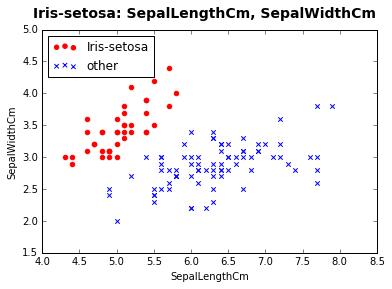

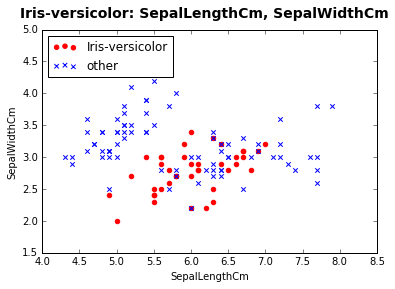

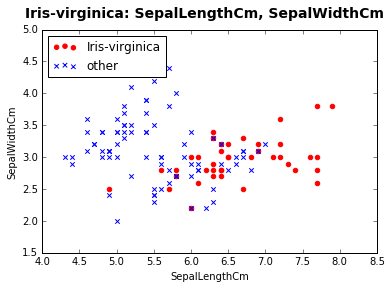

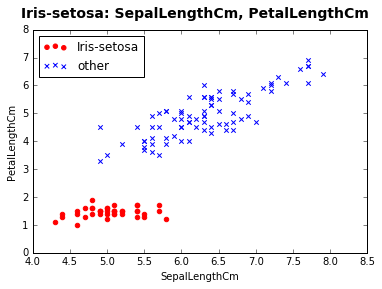

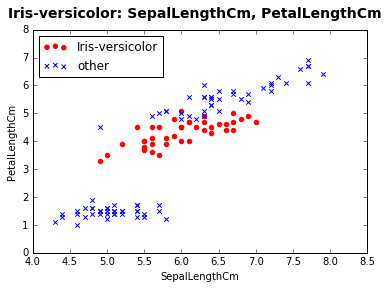

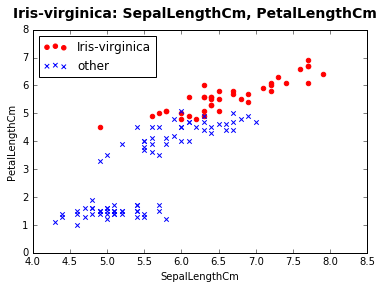

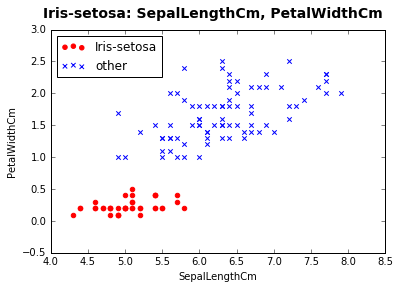

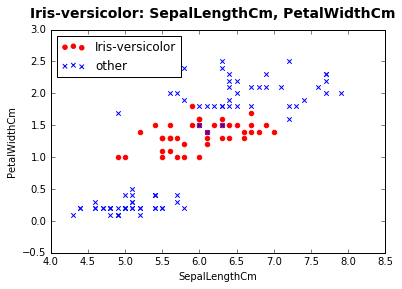

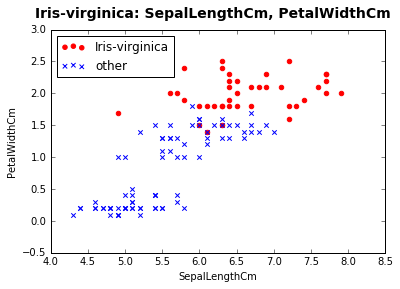

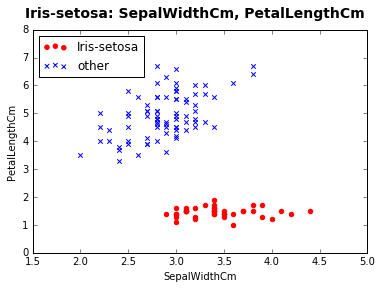

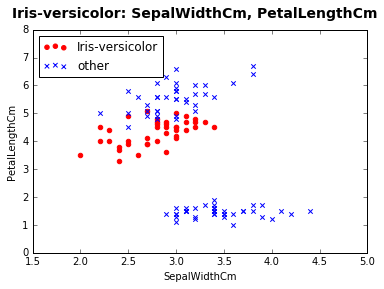

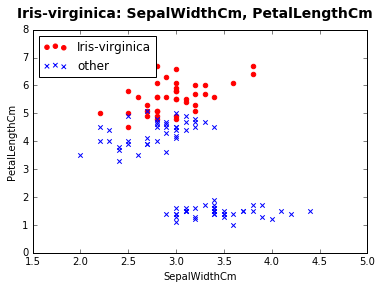

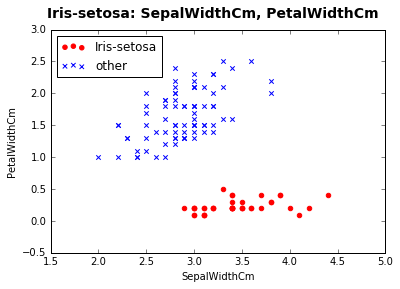

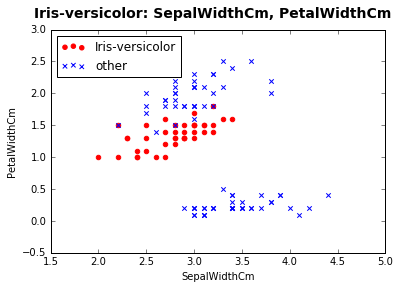

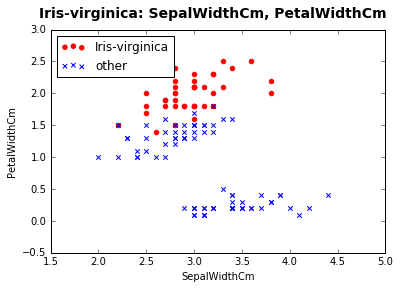

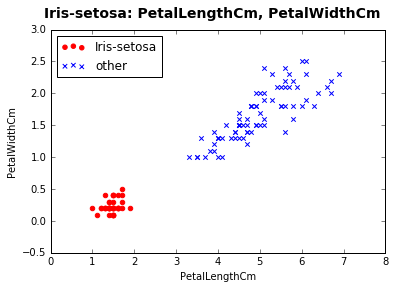

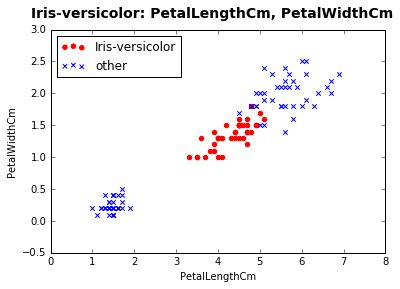

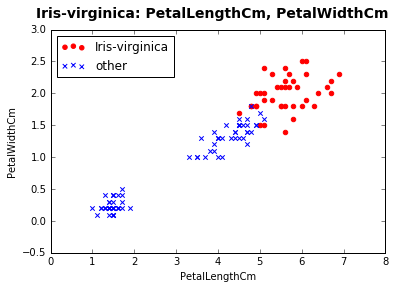

In [26]:
from itertools import chain, combinations
species = list(df['Species'].unique())
features = ['SepalLengthCm','SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

for comb in combinations(features, 2):
    for flower in species:
        fig = plt.figure()
        fig.suptitle(flower + ': ' + comb[0] + ', ' + comb[1], fontsize=14, fontweight='bold')
        plt.scatter(train[train['Species'] == flower][comb[0]], train[train['Species'] == flower][comb[1]], color='red', marker='o', label=flower)
        plt.scatter(train[train['Species'] != flower][comb[0]], train[train['Species'] != flower][comb[1]], color='blue', marker='x', label='other')
        plt.xlabel(comb[0])
        plt.ylabel(comb[1])
        plt.legend(loc='upper left')
        plt.show()

It doesn't seem like there's a pairing of features that gives us linearly separable classes for each flower species, so we can't expect our perceptron learning rule to converge (or else Frank Rosenblatt has some explaining to do).  That being said, let's see how our learning rule fares. We'll use feature combinations of size 2 to 4, and plot the number of misclassifications for each epoch.

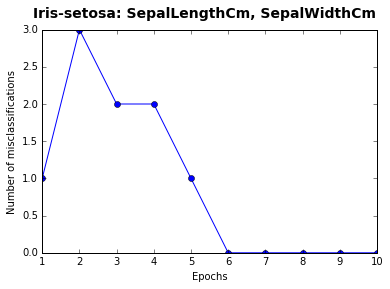

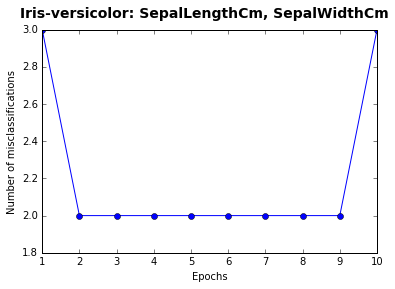

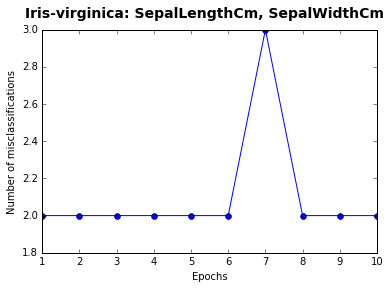

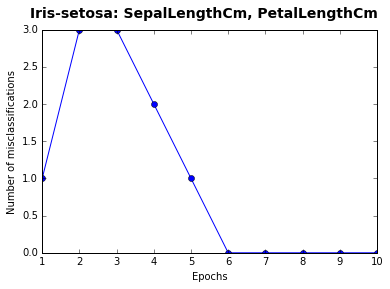

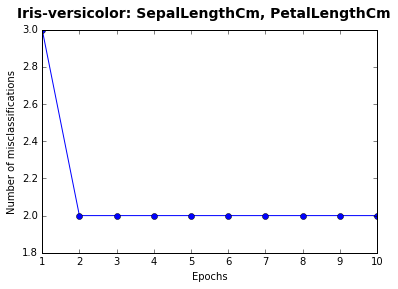

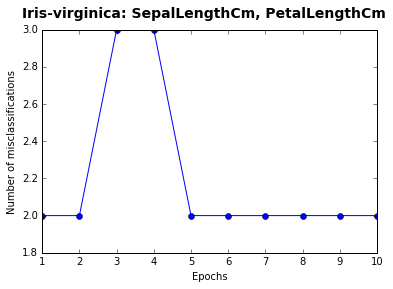

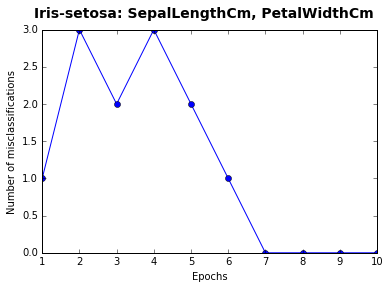

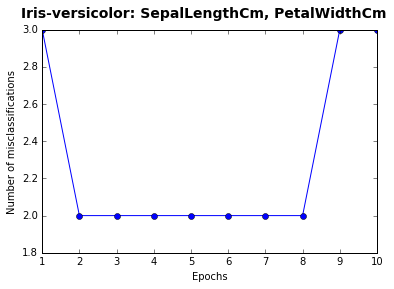

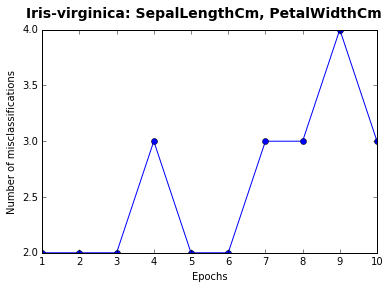

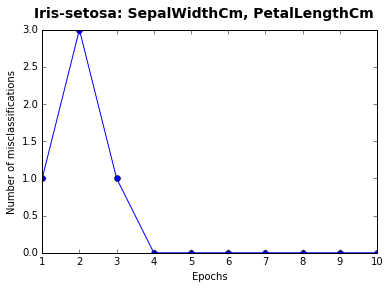

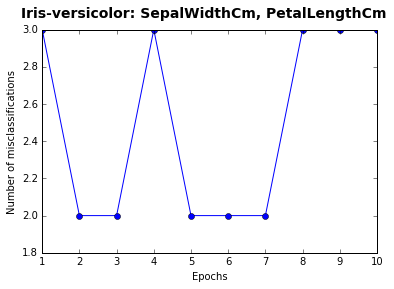

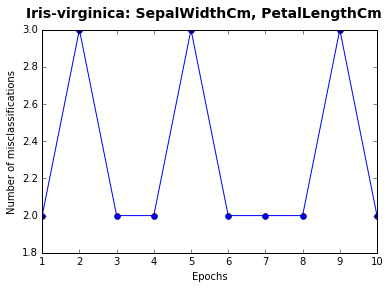

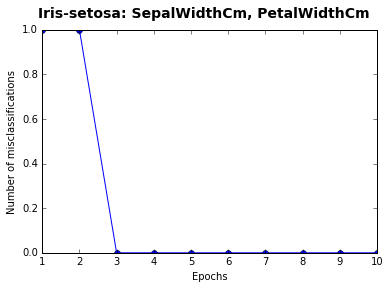

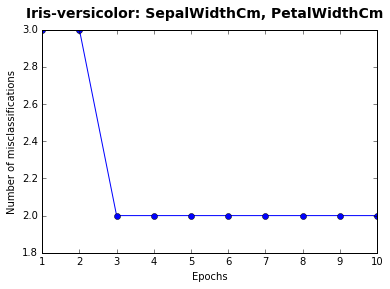

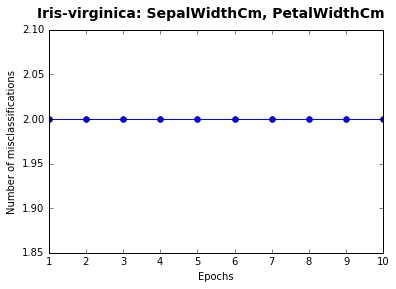

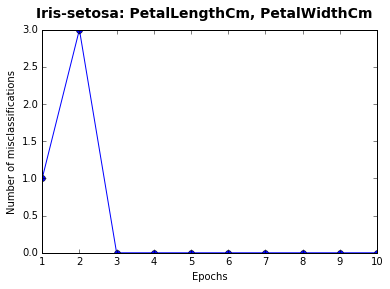

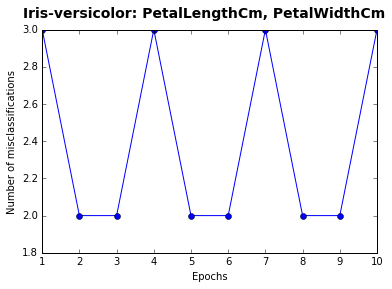

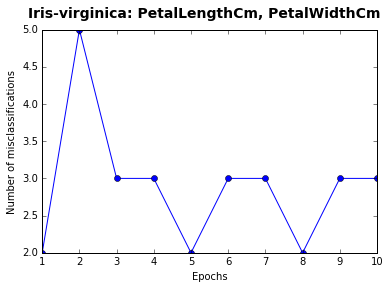

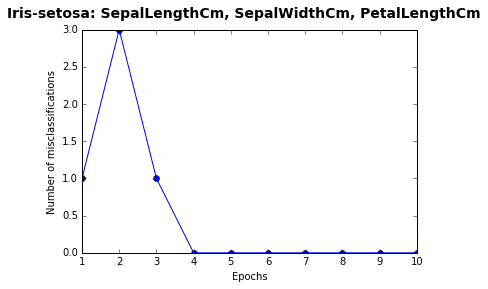

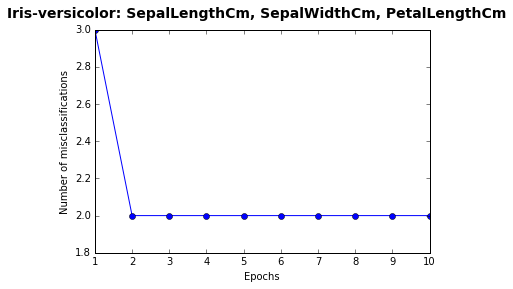

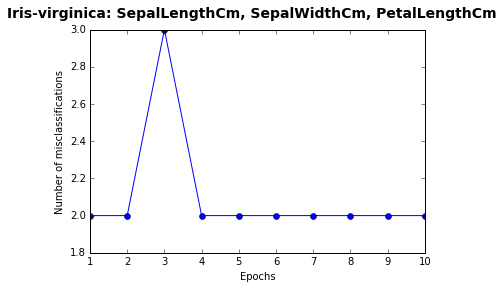

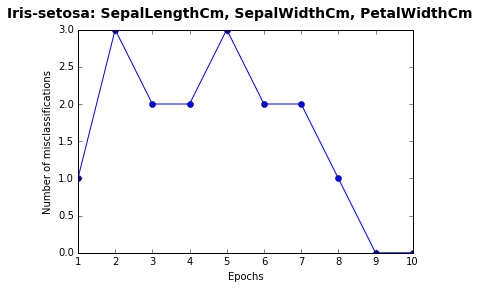

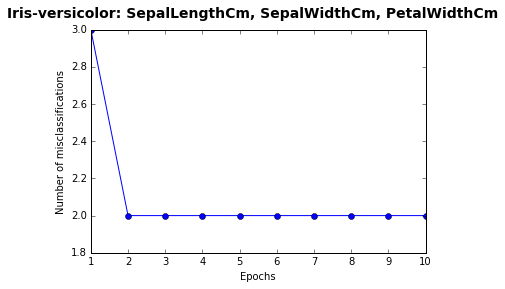

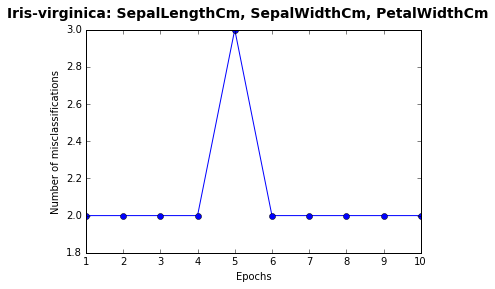

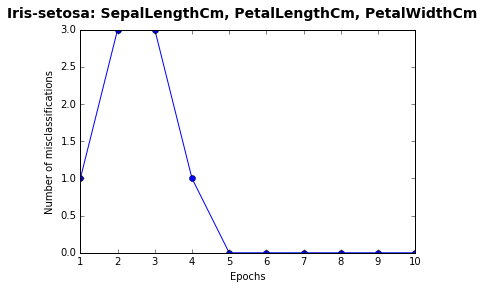

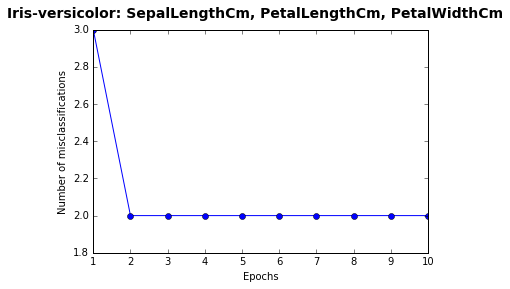

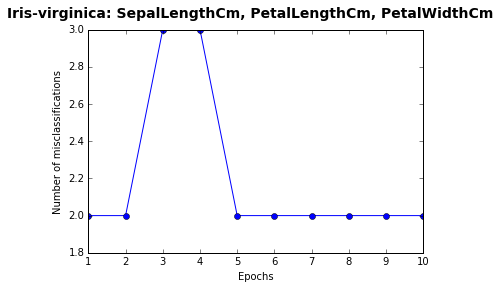

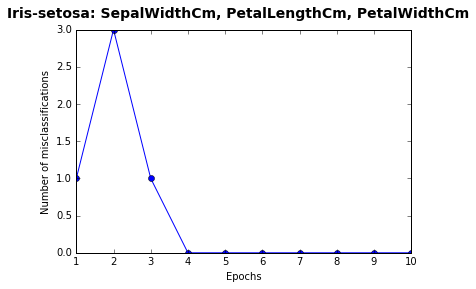

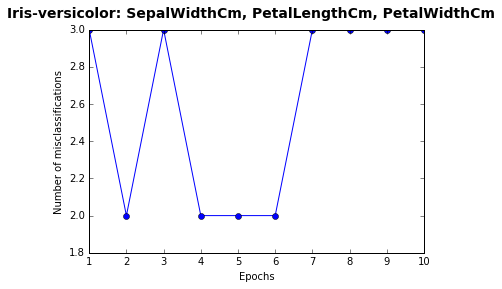

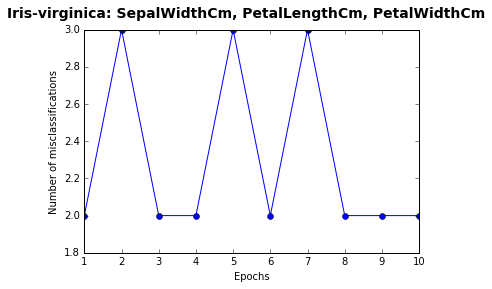

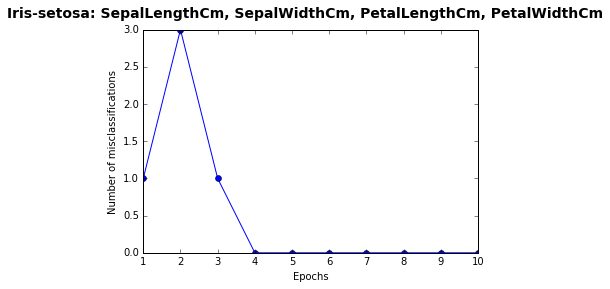

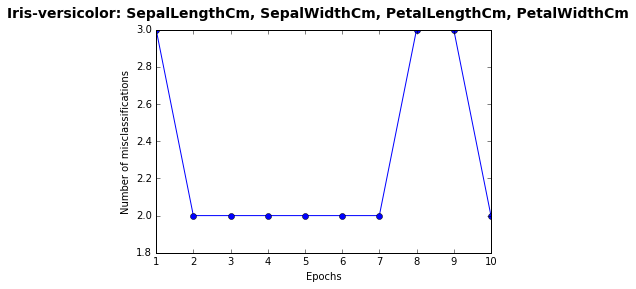

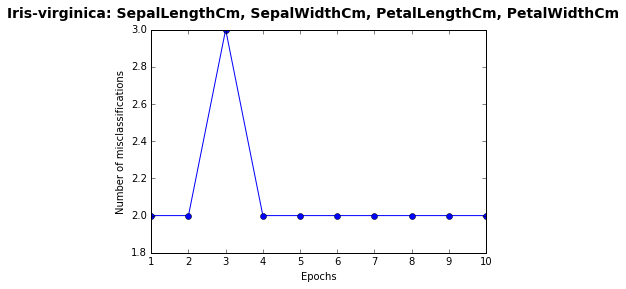

In [37]:
for comb in chain.from_iterable(combinations(features, r) for r in xrange(2, len(features) + 1)):
    for flower in species:
        X = train[[f for f in comb]].values
        y = np.where(train['Species'] == flower, 1, -1)
        ppn = Perceptron(eta=0.1, n_iter=10)
        ppn.fit(X, y)
        fig = plt.figure()
        fig.suptitle(flower + ': ' + ', '.join(comb), fontsize=14, fontweight='bold')
        plt.plot(np.arange(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Number of misclassifications')
        plt.show()

We'll finish by attempting to predict the remaining 30 flowers from the dataset.

In [39]:
import operator
perceptrons = {}
for flower in species:
    X = train[['SepalLengthCm', 'PetalLengthCm']].values
    y = np.where(train['Species'] == flower, 1, -1)
    ppn = Perceptron()
    ppn.fit(X, y)
    perceptrons[flower] = ppn

correct, incorrect = 0, 0
for i in xrange(test.shape[0]):
    sample = test.iloc[i]
    guesses = {}
    for flower in species:
        guesses[flower] = perceptrons[flower].net_input(sample[['SepalLengthCm', 'PetalLengthCm']])
    if sample['Species'] == max(guesses.iteritems(), key=operator.itemgetter(1))[0]:
        correct += 1
    else:
        incorrect += 1
print 'Correct: {}\tIncorrect: {}\t{}'.format(correct, incorrect, float(correct)/test.shape[0])


Correct: 20	Incorrect: 10	0.666666666667


Huh, not very good. We could try messing with the learning rate, number of iterations, number of features, etc., but I'd rather not and move on to playing with some adaptive linear neurons. Below is code using scikit-learn's Perceptron class to verify we get the same result.

In [38]:
from sklearn.linear_model import Perceptron as p
for flower in species:
    X = train[['SepalLengthCm', 'PetalLengthCm']].values
    y = np.where(train['Species'] == flower, 1, -1)
    ppn = p()
    ppn.fit(X, y)
    perceptrons[flower] = ppn
correct, incorrect = 0, 0
for i in xrange(test.shape[0]):
    sample = test.iloc[i]
    guesses = {}
    for flower in species:
        guesses[flower] = perceptrons[flower].decision_function(sample[['SepalLengthCm', 'PetalLengthCm']].reshape(1,-1))
    if sample['Species'] == max(guesses.iteritems(), key=operator.itemgetter(1))[0]:
        correct += 1
    else:
        incorrect += 1
print 'Correct: {}\tIncorrect: {}\t{}'.format(correct, incorrect, float(correct)/test.shape[0])

Correct: 20	Incorrect: 10	0.666666666667
